# 📓 Modelo de OneClassSVM entrenado con datos  Unid (no identificados), y predicción sobre datos DM (drk matter, materia oscura simulada)

**Proyecto**: Detección de posibles fuentes de materia oscura usando ML en datos Fermi-LAT  
**Autor**: Marta Canino Romero  
**Fecha**: febrero-mayo 20225

---

## ✨ Descripción:

Este notebook aplica un modelo **One-Class SVM** entrenado con datos de fuentes astrofísicas desconocidas (UNIDs) usando las siguientes características:

- E_peak
- beta

---

## 📌 Objetivos específicos:

- Entrenar modelo OCSVM con [número de features] 
- Optimizar hiperparámetros (grid search sobre `nu` y `gamma`)
- Evaluar sobre datos de validación y prueba
- Aplicar modelo final sobre datos UNID para predicción

---

## 🗂️ Entrada de datos:

- `../../data/raw/unids_3F_beta_err_names.txt`

## 💾 Salida esperada:

- Mejor combinación de hiperparámetros
- Métricas de evaluación (f1-score, confusion matrix)
- Exportación de los UNIDs más anómalos


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
unids_path = "../../data/raw/unids_3F_beta_err_names.txt"
df_unids = pd.read_csv(unids_path, sep='\s+')
df_unids.head()

,E_peak,beta,sigma_det,beta_Rel,number
0,2.51290,0.0897,7.3996,1.630992,0
1,1.47820,0.4163,5.4150,0.770838,1
2,1.59640,0.6783,10.7909,0.371222,2
3,0.93095,0.2771,7.6056,0.628654,3
4,0.44480,0.3207,4.2748,0.567509,4


In [3]:
# Apply log10 to data
cols_to_log = ["E_peak", "beta", "sigma_det", "beta_Rel"] # Aplicamos la transformación a todas las columnas aunque solo usemos 2
df_unids_log = df_unids.copy()
df_unids_log[cols_to_log] = df_unids_log[cols_to_log].apply(lambda x: np.log10(x.clip(lower=1e-10)))


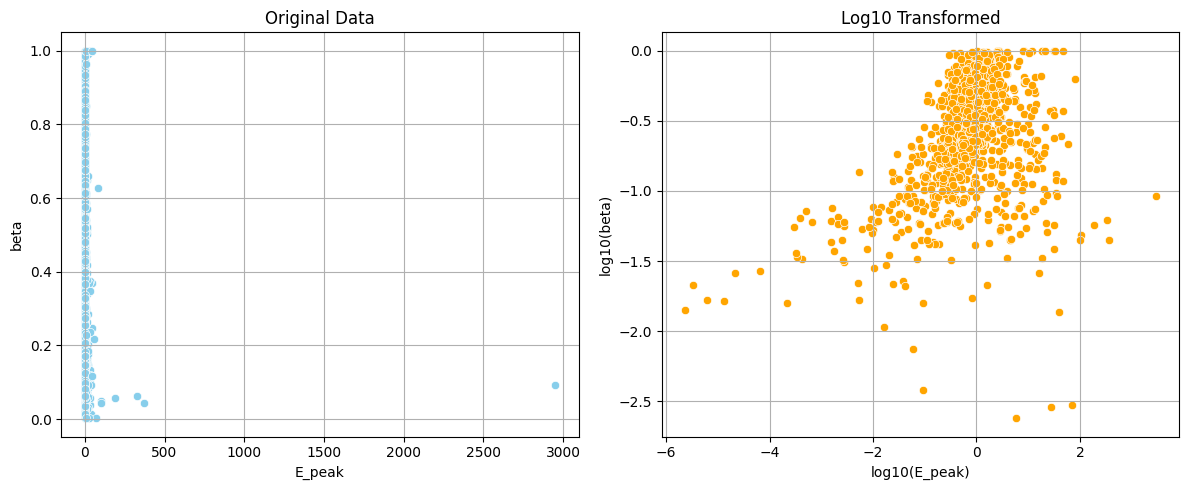

In [4]:
plt.figure(figsize=(18, 5))

# Original
plt.subplot(1, 3, 1)
sns.scatterplot(data=df_unids, x="E_peak", y="beta", color="skyblue")
plt.title("Original Data")
plt.xlabel("E_peak")
plt.ylabel("beta")
plt.grid(True)

# Log10
plt.subplot(1, 3, 2)
sns.scatterplot(data=df_unids_log, x="E_peak", y="beta", color="orange")
plt.title("Log10 Transformed")
plt.xlabel("log10(E_peak)")
plt.ylabel("log10(beta)")
plt.grid(True)

plt.tight_layout()
plt.show()

In [5]:
# Extract features and IDs
X = df_unids_log[["beta", "E_peak"]].values
y = df_unids_log["number"].values

# === SPLIT: Train / Val / Test ===
# First split into train and temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
# Then split temp into val and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [6]:
# Create split column with default value
df_unids_log['split'] = 'unused'

# Set split labels by matching 'number'
df_unids_log.loc[df_unids_log['number'].isin(y_train), 'split'] = 'train'
df_unids_log.loc[df_unids_log['number'].isin(y_val), 'split'] = 'val'
df_unids_log.loc[df_unids_log['number'].isin(y_test), 'split'] = 'test'

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [8]:
nu_values = [0.01, 0.02, 0.05, 0.1]
gamma_values = ['scale', 'auto'] + list(np.logspace(-3, 1, 5))  # 0.001 to 10

results = []
best_score = np.inf
best_model = None
best_params = {}

for nu in nu_values:
    for gamma in gamma_values:
        model = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
        model.fit(X_train_scaled)
        
        # Predict on validation set
        preds = model.predict(X_val_scaled)
        n_outliers = np.sum(preds == -1)  # -1 means "anomaly"
        
        results.append({'nu': nu, 'gamma': gamma, 'outliers': n_outliers})
        
        if n_outliers < best_score:
            best_score = n_outliers
            best_model = model
            best_params = {'nu': nu, 'gamma': gamma}

# Show best hyperparameters
print(f"✅ Best Parameters: nu = {best_params['nu']}, gamma = {best_params['gamma']}")
print(f"🚨 Outliers on Validation Set: {best_score}")


✅ Best Parameters: nu = 0.01, gamma = 0.001
🚨 Outliers on Validation Set: 0


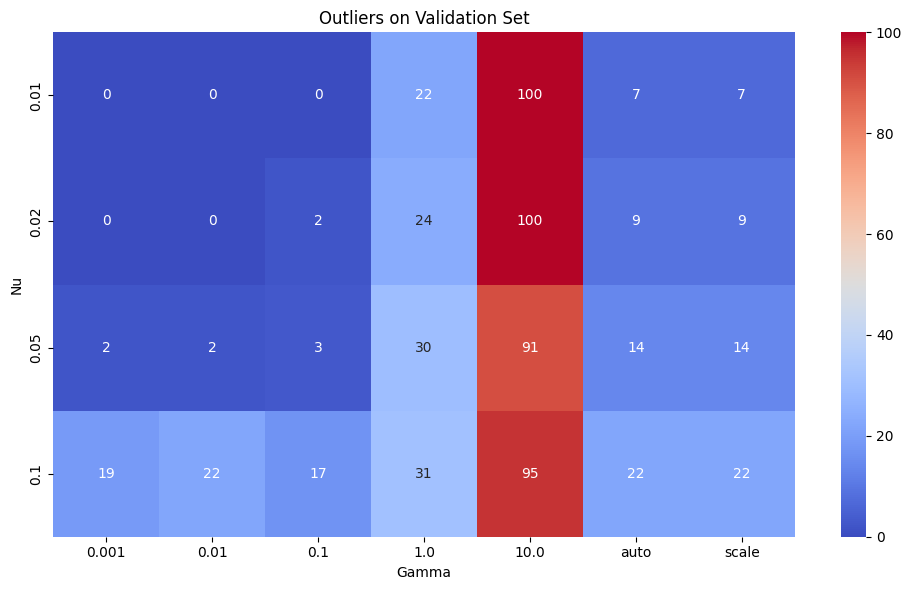

In [9]:
df_results = pd.DataFrame(results)
df_results['gamma_str'] = df_results['gamma'].astype(str)
heatmap_data = df_results.pivot(index='nu', columns='gamma_str', values='outliers')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='coolwarm')
plt.title("Outliers on Validation Set")
plt.xlabel("Gamma")
plt.ylabel("Nu")
plt.tight_layout()
plt.show()


In [10]:
# Evaluate on the test set
test_preds = best_model.predict(X_test_scaled)
n_test_outliers = np.sum(test_preds == -1)

print(f"🔍 Outliers on Final Test Set: {n_test_outliers}")

🔍 Outliers on Final Test Set: 1


In [11]:
scores_test = best_model.decision_function(X_test_scaled)
outliers_by_score = np.sum(scores_test < 0)

print(f"Outliers by actual decision function: {outliers_by_score}")
print(f"Test min score: {scores_test.min()}, Max score: {scores_test.max()}")


Outliers by actual decision function: 1
Test min score: -0.0016160217440717162, Max score: 0.1273781684502504


In [12]:
val_preds = best_model.predict(X_val_scaled)
print(f"Outliers on Validation Set (double check): {np.sum(val_preds == -1)}")

test_preds = best_model.predict(X_test_scaled)
print(f"Outliers on Test Set (final eval): {np.sum(test_preds == -1)}")

train_preds = best_model.predict(X_train_scaled)
print(f"Outliers on Training Set: {np.sum(train_preds == -1)}")

print(f"📊 Outliers:")
print(f"- Training set: {np.sum(train_preds == -1)}")
print(f"- Validation set: {np.sum(val_preds == -1)}")
print(f"- Test set: {np.sum(test_preds == -1)}")


Outliers on Validation Set (double check): 0
Outliers on Test Set (final eval): 1
Outliers on Training Set: 8
📊 Outliers:
- Training set: 8
- Validation set: 0
- Test set: 1


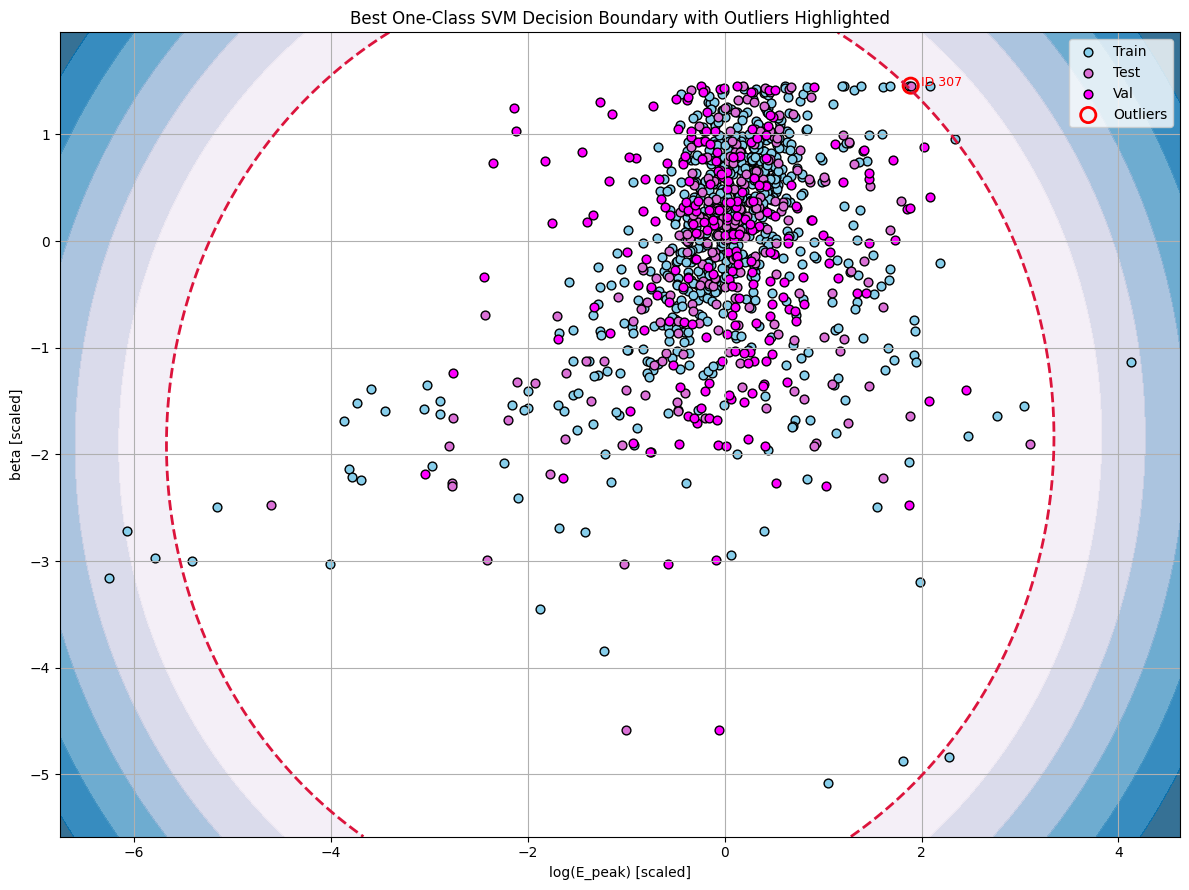

In [13]:
# === Create meshgrid ===
xx, yy = np.meshgrid(
    np.linspace(X_train_scaled[:, 1].min() - 0.5, X_train_scaled[:, 1].max() + 0.5, 300),  # E_peak
    np.linspace(X_train_scaled[:, 0].min() - 0.5, X_train_scaled[:, 0].max() + 0.5, 300)   # beta
)

grid = np.c_[yy.ravel(), xx.ravel()]
Z = best_model.decision_function(grid)
Z = Z.reshape(xx.shape)

# === Get latest predictions and outlier indices ===
test_preds = best_model.predict(X_test_scaled)
scores_test = best_model.decision_function(X_test_scaled)
outlier_indices = np.where(test_preds == -1)[0]

# === Plot ===
plt.figure(figsize=(12, 9))

# Decision function contour
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu_r, alpha=0.8)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='crimson', linestyles='--')

# Training data
plt.scatter(X_train_scaled[:, 1], X_train_scaled[:, 0],
            c='skyblue', edgecolors='k', s=40, label='Train')

# Test data
plt.scatter(X_test_scaled[:, 1], X_test_scaled[:, 0],
            c='orchid', edgecolors='k', s=40, label='Test')

# Val data
plt.scatter(X_val_scaled[:, 1], X_test_scaled[:, 0],
            c='magenta', edgecolors='k', s=40, label='Val')

# Outliers
plt.scatter(X_test_scaled[outlier_indices, 1],
            X_test_scaled[outlier_indices, 0],
            facecolors='none', edgecolors='red', linewidths=2, s=120, label='Outliers')

# Optional: annotate outlier IDs
for i in outlier_indices:
    plt.text(
        X_test_scaled[i, 1] + 0.1,
        X_test_scaled[i, 0],
        f"ID {y_test[i]}",
        color='red',
        fontsize=9
    )

# Axis labels and formatting
plt.xlabel("log(E_peak) [scaled]")
plt.ylabel("beta [scaled]")
plt.title("Best One-Class SVM Decision Boundary with Outliers Highlighted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


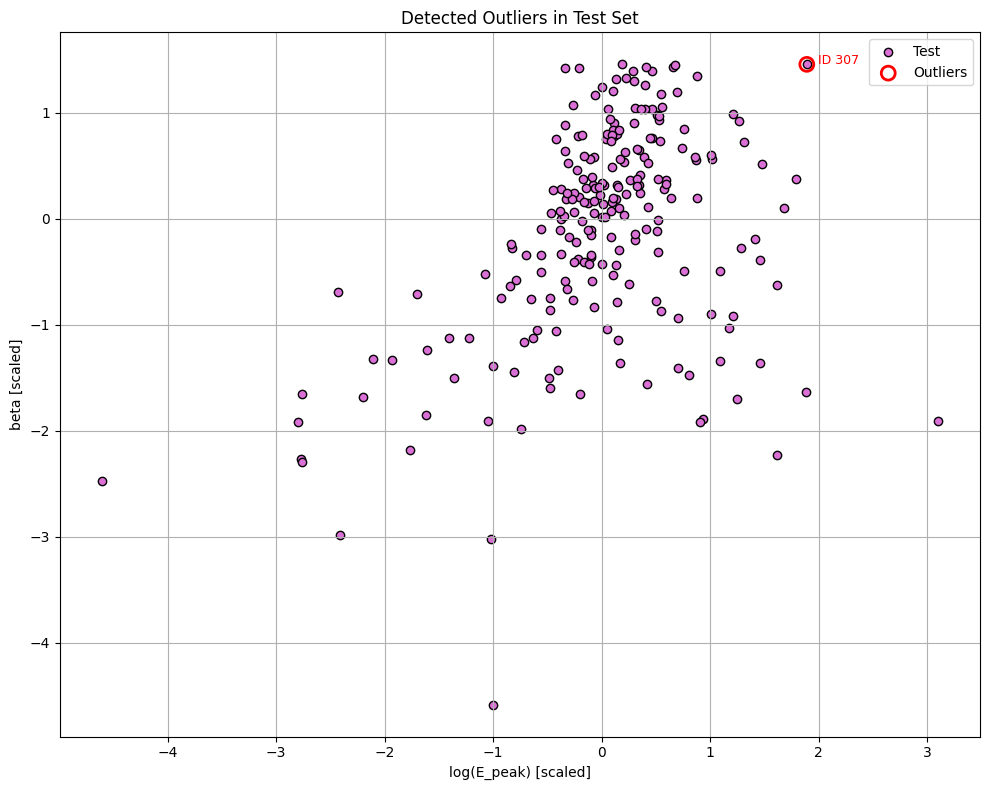

In [14]:
plt.figure(figsize=(10, 8))
plt.scatter(X_test_scaled[:, 1], X_test_scaled[:, 0], c='orchid', label="Test", edgecolors='k')

# Highlight the 2 outliers in red
plt.scatter(
    X_test_scaled[outlier_indices, 1], X_test_scaled[outlier_indices, 0],
    facecolors='none', edgecolors='red', linewidths=2, s=100, label="Outliers"
)

for i in outlier_indices:
    plt.text(
        X_test_scaled[i, 1] + 0.1,
        X_test_scaled[i, 0],
        f"ID {y_test[i]}",
        color='red', fontsize=9
    )

plt.xlabel("log(E_peak) [scaled]")
plt.ylabel("beta [scaled]")
plt.title("Detected Outliers in Test Set")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Predict on DM Data

In [15]:
dm_data_path = "../../data/processed/XY_bal_log_Rel/DM/XY_bal_log_Rel_DM.txt"
df_dm = pd.read_csv(dm_data_path, sep='\s+')
df_dm = df_dm.rename(columns={"0,1=astro,DM": "class"})  # 1.0 = DM, 0.0 = ASTRO

df_dm.head()

,E_peak,beta,sigma,beta_Rel,class
0,2.518909,-0.313990,0.987488,0.528569,1.0
1,1.922881,-0.659556,1.345178,0.395713,1.0
2,2.463445,-0.534617,0.792322,0.288124,1.0
3,2.571126,-1.246647,0.694254,0.447771,1.0
4,1.386499,-0.951947,1.098990,-0.412871,1.0


In [16]:
# Extraer y escalar para predicción
X_dm = df_dm[["beta", "E_peak"]].values
X_dm_scaled = scaler.transform(X_dm)

df_dm_scaled = pd.DataFrame(X_dm_scaled, columns=["beta_scaled", "E_peak_scaled"])

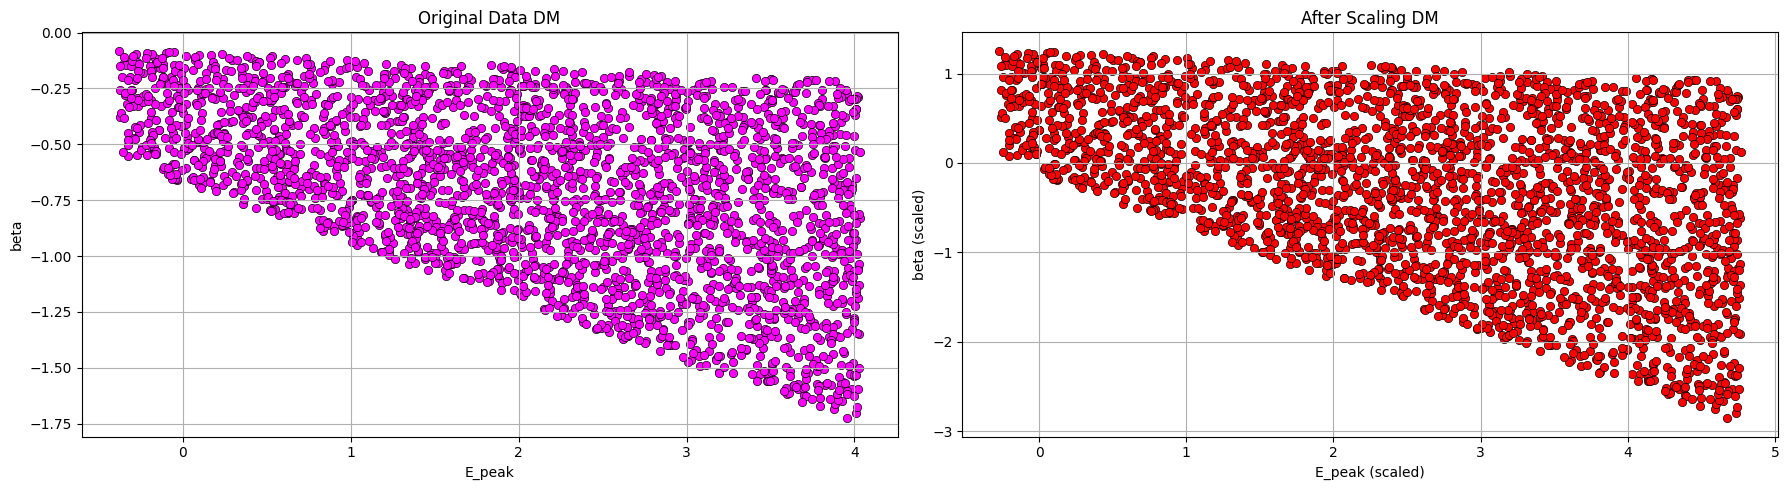

In [17]:
plt.figure(figsize=(18, 5))

# Original
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_dm, x="E_peak", y="beta", color="magenta", edgecolor='k')
plt.title("Original Data DM")
plt.xlabel("E_peak")
plt.ylabel("beta")
plt.grid(True)

# Scaled
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_dm_scaled, x="E_peak_scaled", y="beta_scaled", color="red", edgecolor='k')
plt.title("After Scaling DM")
plt.xlabel("E_peak (scaled)")
plt.ylabel("beta (scaled)")
plt.grid(True)

plt.tight_layout()
plt.show()

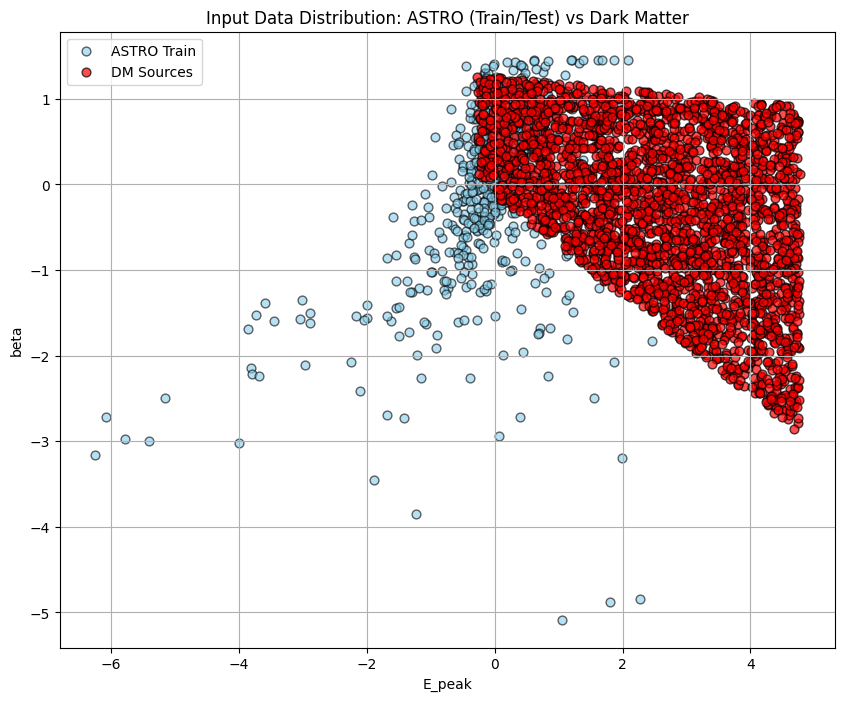

In [18]:
plt.figure(figsize=(10, 8))

# Plot ASTRO training and test data
plt.scatter(X_train_scaled[:, 1], X_train_scaled[:, 0], 
            c='skyblue', edgecolors='k', label='ASTRO Train', alpha=0.6, s=40)

# Plot DM data
plt.scatter(X_dm_scaled[:, 1], X_dm_scaled[:, 0], 
            c='red', edgecolors='k', label='DM Sources', alpha=0.7, s=40)

plt.xlabel("E_peak")
plt.ylabel("beta")
plt.title("Input Data Distribution: ASTRO (Train/Test) vs Dark Matter")
plt.grid(True)
plt.legend(loc='upper left')

plt.show()

In [19]:
# Predict on DM data
dm_preds = best_model.predict(X_dm_scaled)  # +1 = normal (UNID-like), -1 = anomaly
dm_scores = best_model.decision_function(X_dm_scaled)  # higher = more "normal"

In [20]:
# Add predictions and scores to DataFrame
df_dm["ocsvm_prediction"] = dm_preds
df_dm["ocsvm_score"] = dm_scores

df_dm.head()

,E_peak,beta,sigma,beta_Rel,class,ocsvm_prediction,ocsvm_score
0,2.518909,-0.313990,0.987488,0.528569,1.0,-1,-0.023890
1,1.922881,-0.659556,1.345178,0.395713,1.0,1,0.031658
2,2.463445,-0.534617,0.792322,0.288124,1.0,-1,-0.004886
3,2.571126,-1.246647,0.694254,0.447771,1.0,1,0.013147
4,1.386499,-0.951947,1.098990,-0.412871,1.0,1,0.068405


In [21]:
# Check summmary stats
n_anomalies = np.sum(dm_preds == -1)
n_normals = np.sum(dm_preds == 1)

print(f"🪐 Predicted UNID-like (Normal): {n_normals}")
print(f"🧊 Predicted Anomalies (Not UNID-like, maybe ASTRO): {n_anomalies}")

# Normalize anomaly scores
anom_percent = MinMaxScaler((0, 100)).fit_transform(-dm_scores.reshape(-1, 1)).flatten()
df_dm["anom_percent"] = anom_percent

🪐 Predicted UNID-like (Normal): 1621
🧊 Predicted Anomalies (Not UNID-like, maybe ASTRO): 1210


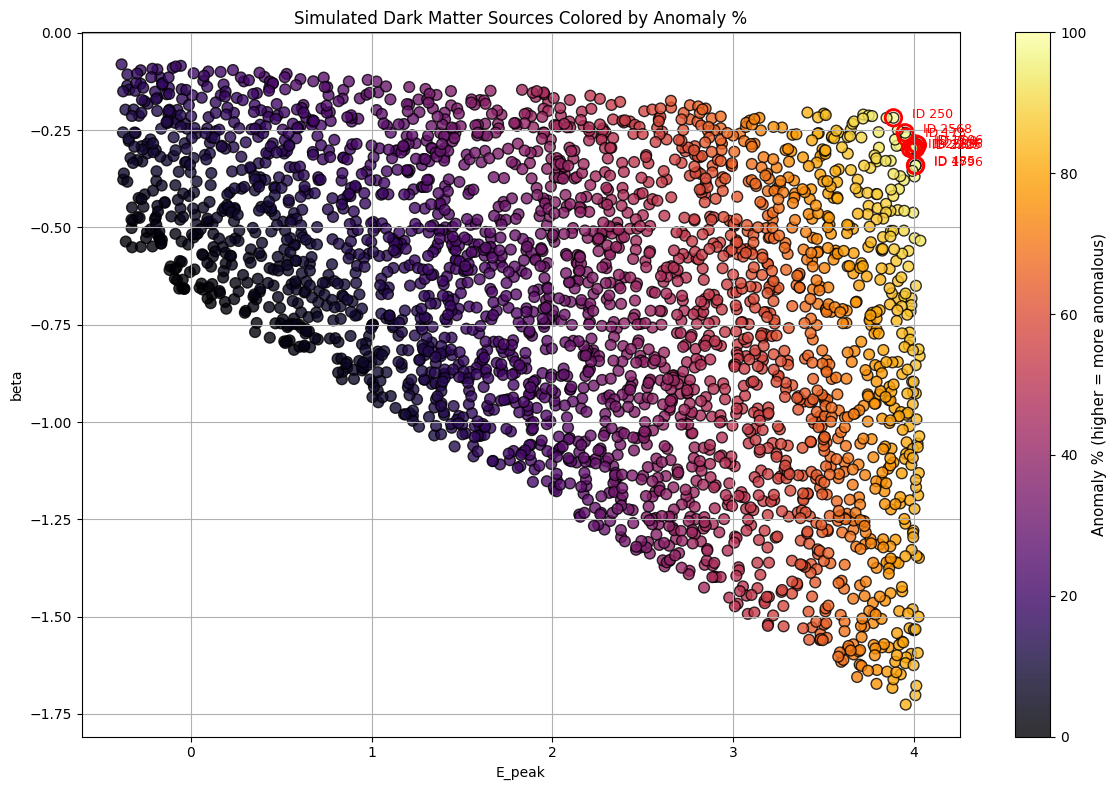

In [22]:
# Top N most anomalous
N = 10
most_anomalous_idx = np.argsort(-anom_percent)[:N]
top_ids = df_dm.iloc[most_anomalous_idx].index.values
top_scores = anom_percent[most_anomalous_idx]

plt.figure(figsize=(12, 8))

# Full scatter, colored by anomaly %
scatter = plt.scatter(
    df_dm["E_peak"],
    df_dm["beta"],
    c=df_dm["anom_percent"],
    cmap="inferno",
    edgecolors="k",
    s=60,
    alpha=0.8
)

cbar = plt.colorbar(scatter)
cbar.set_label("Anomaly % (higher = more anomalous)", fontsize=11)

# Highlight & label top anomalies
for i, idx in enumerate(most_anomalous_idx):
    row = df_dm.iloc[idx]
    plt.scatter(row["E_peak"], row["beta"],
                facecolors='none', edgecolors='red', s=140, linewidths=2)
    plt.text(row["E_peak"] + 0.1, row["beta"], f"ID {row.name}", fontsize=9, color='red')

# Final plot style
plt.xlabel("E_peak")
plt.ylabel("beta")
plt.title("Simulated Dark Matter Sources Colored by Anomaly %")
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/m8/9rd44wvx47j51lczw45sffl40000gn/T/ipykernel_13241/419040496.py:18: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='crimson', linestyles='--', label='Decision Boundary')


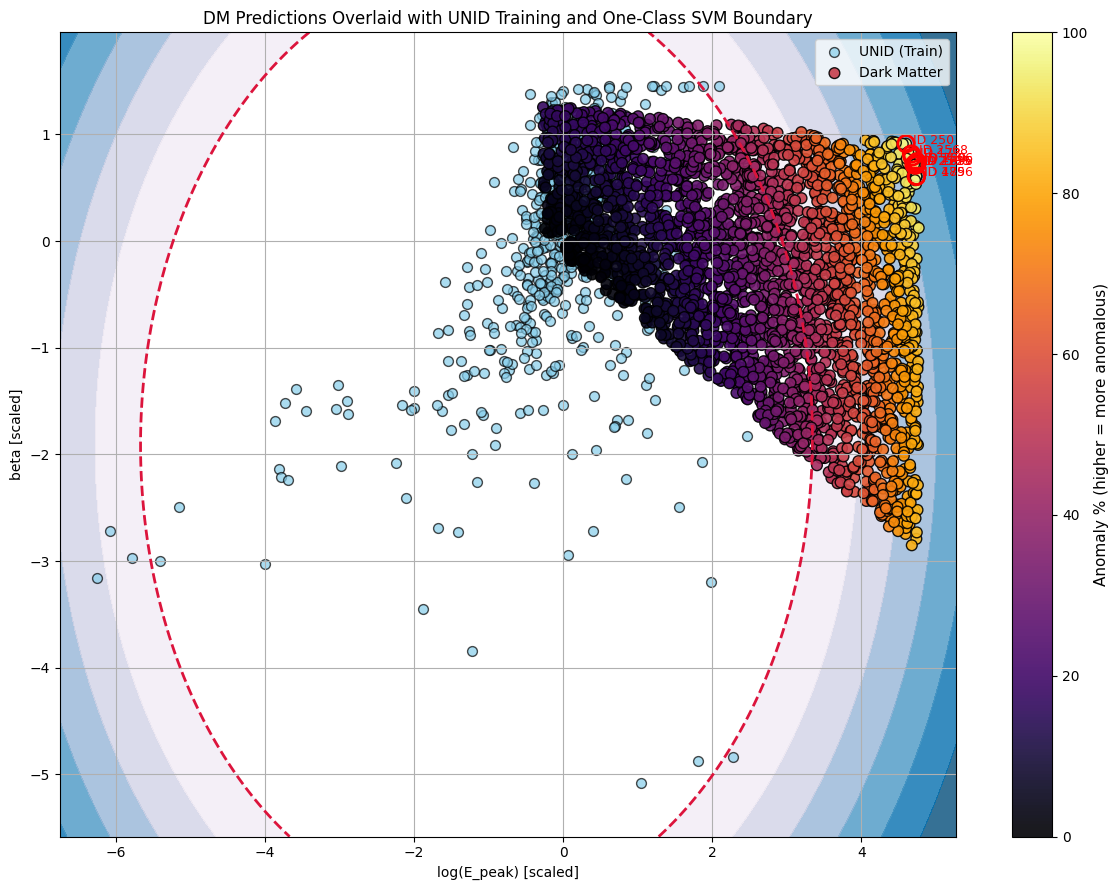

In [23]:
# === Create Meshgrid for Decision Function (same scale as DM + UNID)
xx, yy = np.meshgrid(
    np.linspace(min(X_train_scaled[:, 1].min(), X_dm_scaled[:, 1].min()) - 0.5,
                max(X_train_scaled[:, 1].max(), X_dm_scaled[:, 1].max()) + 0.5, 400),
    np.linspace(min(X_train_scaled[:, 0].min(), X_dm_scaled[:, 0].min()) - 0.5,
                max(X_train_scaled[:, 0].max(), X_dm_scaled[:, 0].max()) + 0.5, 400)
)

grid = np.c_[yy.ravel(), xx.ravel()]
Z = best_model.decision_function(grid)
Z = Z.reshape(xx.shape)

# === Plot
plt.figure(figsize=(12, 9))

# Background: Decision function contour
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu_r, alpha=0.8)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='crimson', linestyles='--', label='Decision Boundary')

# UNID training data (normal class)
plt.scatter(
    X_train_scaled[:, 1],  # E_peak
    X_train_scaled[:, 0],  # beta
    c='skyblue',
    edgecolors='k',
    s=50,
    label='UNID (Train)',
    alpha=0.7
)

# Simulated Dark Matter points
scatter = plt.scatter(
    X_dm_scaled[:, 1],
    X_dm_scaled[:, 0],
    c=anom_percent,
    cmap='inferno',
    edgecolors='k',
    s=60,
    alpha=0.9,
    label='Dark Matter'
)

# Highlight top N anomalies in DM
for i in most_anomalous_idx:
    x = X_dm_scaled[i, 1]
    y = X_dm_scaled[i, 0]
    plt.scatter(x, y, facecolors='none', edgecolors='red', s=140, linewidths=2)
    plt.text(x + 0.1, y, f"ID {df_dm.index[i]}", color='red', fontsize=9)

# Colorbar for anomaly %
cbar = plt.colorbar(scatter)
cbar.set_label("Anomaly % (higher = more anomalous)", fontsize=11)

# Axes and formatting
plt.xlabel("log(E_peak) [scaled]")
plt.ylabel("beta [scaled]")
plt.title("DM Predictions Overlaid with UNID Training and One-Class SVM Boundary")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
# Sort by highest anomaly percentage (most anomalous at top)
top_dm_anomalies = df_dm.sort_values("anom_percent", ascending=False).head(10)

# Show key info
print("Top 10 Most Anomalous Simulated Dark Matter Sources:")
display(top_dm_anomalies[["beta", "E_peak", "ocsvm_score", "anom_percent"]])


Top 10 Most Anomalous Simulated Dark Matter Sources:


,beta,E_peak,ocsvm_score,anom_percent
700,-0.288024,4.019116,-0.131816,100.000000
1506,-0.285754,4.012837,-0.131485,99.856590
1636,-0.296967,4.009876,-0.130346,99.363182
2225,-0.297914,3.998041,-0.129304,98.912180
2568,-0.256647,3.950900,-0.128827,98.705630
173,-0.268009,3.958325,-0.128492,98.560461
2588,-0.296967,3.979821,-0.127897,98.302513
485,-0.340369,4.009451,-0.126929,97.883600
250,-0.218173,3.886378,-0.126891,97.867122
1796,-0.341035,4.008174,-0.126774,97.816409
